### RFM分析有2種切分方式，一種是用k-means分群、另一種是去判斷各項RFM的名次，並區分成8種樣態。
### 或許可以比較2者差異

### https://towardsdatascience.com/who-is-your-golden-goose-cohort-analysis-50c9de5dbd31

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('transaction_data_version1.csv')

In [3]:
df = df.drop('Unnamed: 0',axis=1)

In [4]:
from datetime import datetime
from datetime import timedelta

Begindatestring = "2019-7-29"
Begindate = datetime.strptime(Begindatestring, "%Y-%m-%d")

df['date'] = df['DAY'].map(lambda x : Begindate + timedelta(days=x))

In [5]:
df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,TRANS_TIME,WEEK_NO,date
0,2375,26984851472,1,1004906,1,1.39,364,1631,1,2019-07-30
1,1929,27021022215,4,1004906,1,1.39,441,1755,1,2019-08-02
2,568,27021090189,4,1004906,1,1.39,446,35,1,2019-08-02
3,887,27031467254,5,1004906,1,1.39,298,1551,1,2019-08-03
4,175,27057508267,7,1004906,1,1.99,446,2303,2,2019-08-05


## RFM架構：R、F、M 三項指標的定義
### RFM模型是喬治．卡利南（George Cullinan）在1961年提出的顧客分群方法，其中三項指標分別是：

- 最近一次消費（Recency）：Recency反應的是顧客的活躍度，指顧客距離最後一次消費，有幾天沒回來消費。
- 消費頻率（Frequency）：Frequency能反映顧客對品牌的忠誠度，指顧客在一段期間內，回來消費幾次。
- 消費金額（Monetary）：Monetary能幫你分辨真正的「貴客」，指顧客在一段期間內，累積消費金額是多少。

### https://www.kaggle.com/ashydv/customer-clustering-k-means-clustering

### Extracting R (Recency), F (Frequency), M (Monetary) columns form the data.

### 只需要household_key、BASKET_ID、SALES_VALUE、date欄位

### 購買金額(Monetary)

In [6]:
# Finding total amount spent per customer

monetary = df.groupby('household_key').SALES_VALUE.sum()
monetary = monetary.reset_index()
monetary.head()

,household_key,SALES_VALUE
0,1,4310.16
1,2,1948.09
2,3,2633.20
3,4,1198.62
4,5,779.06


### 購買頻率(Frequency)

In [7]:
# Getting the count of orders made by each customer based on household_key.

frequency = df.groupby("household_key").BASKET_ID.count()
frequency = frequency.reset_index()
frequency.head()


,household_key,BASKET_ID
0,1,1708
1,2,711
2,3,920
3,4,299
4,5,222


### Merging Amount and Frequency columns

In [8]:
#creating master dataset

master = monetary.merge(frequency, on = 'household_key', how = 'inner')
master.head()


,household_key,SALES_VALUE,BASKET_ID
0,1,4310.16,1708
1,2,1948.09,711
2,3,2633.20,920
3,4,1198.62,299
4,5,779.06,222


### Recency Value

In [9]:
# Finding max data
maximum = max(df.date)
maximum

Timestamp('2021-07-09 00:00:00')

In [10]:
# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.
maximum_add1 = maximum + pd.DateOffset(days = 1)
maximum_add1

Timestamp('2021-07-10 00:00:00')

In [11]:
df['diff'] = maximum_add1 - df.date
df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,TRANS_TIME,WEEK_NO,date,diff
0,2375,26984851472,1,1004906,1,1.39,364,1631,1,2019-07-30,711 days
1,1929,27021022215,4,1004906,1,1.39,441,1755,1,2019-08-02,708 days
2,568,27021090189,4,1004906,1,1.39,446,35,1,2019-08-02,708 days
3,887,27031467254,5,1004906,1,1.39,298,1551,1,2019-08-03,707 days
4,175,27057508267,7,1004906,1,1.99,446,2303,2,2019-08-05,705 days


In [12]:
#Dataframe merging by recency

recency = df.groupby("household_key")['diff'].min()
recency = recency.reset_index()
recency.head()

,household_key,diff
0,1,6 days
1,2,44 days
2,3,9 days
3,4,85 days
4,5,9 days


### RFM combined DataFrame

In [13]:
#Combining all recency, frequency and monetary parameters
RFM = master.merge(recency, on = "household_key")
RFM.columns = ['household_key','SALES_VALUE','Frequency','Recency']
RFM

,household_key,SALES_VALUE,Frequency,Recency
0,1,4310.16,1708,6 days
1,2,1948.09,711,44 days
2,3,2633.20,920,9 days
3,4,1198.62,299,85 days
4,5,779.06,222,9 days
...,...,...,...,...
2495,2496,3945.64,1458,29 days
2496,2497,6969.47,1948,12 days
2497,2498,2529.15,855,2 days
2498,2499,3047.48,1151,3 days


In [14]:
RFM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   household_key  2500 non-null   int64          
 1   SALES_VALUE    2500 non-null   float64        
 2   Frequency      2500 non-null   int64          
 3   Recency        2500 non-null   timedelta64[ns]
dtypes: float64(1), int64(2), timedelta64[ns](1)
memory usage: 97.7 KB


In [15]:
import matplotlib.pyplot as plt 
import seaborn as sns

C:\Users\Tibame_25\.conda\envs\kaggle_data\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Tibame_25\.conda\envs\kaggle_data\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Tibame_25\.conda\envs\kaggle_data\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

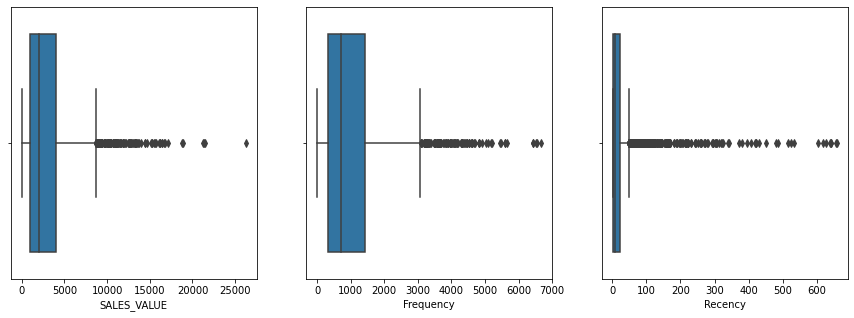

In [16]:
# outlier treatment for Amount
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(RFM.SALES_VALUE, ax = axs[0])
sns.boxplot(RFM.Frequency, ax = axs[1])
sns.boxplot(RFM.Recency.dt.days, ax = axs[2])

plt.tight_layout
plt.show()

In [17]:
# outlier treatment for Amount
Q1 = RFM.SALES_VALUE.quantile(0.25)
Q3 = RFM.SALES_VALUE.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.SALES_VALUE >= Q1 - 1.5*IQR) & (RFM.SALES_VALUE <= Q3 + 1.5*IQR)]

In [18]:
# outlier treatment for Frequency
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

In [19]:
# outlier treatment for Recency
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

C:\Users\Tibame_25\.conda\envs\kaggle_data\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Tibame_25\.conda\envs\kaggle_data\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Tibame_25\.conda\envs\kaggle_data\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

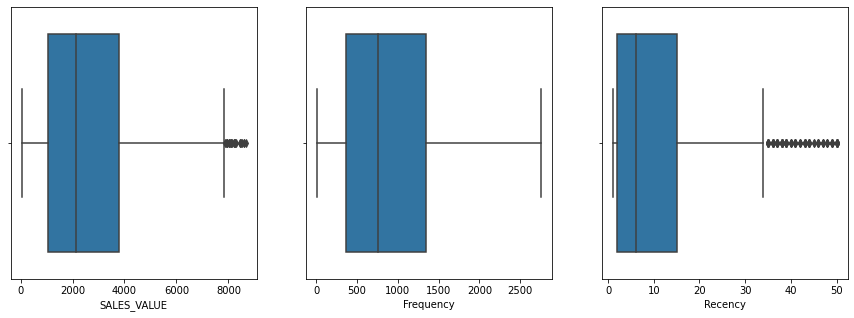

In [20]:
# outlier treatment for Amount
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(RFM.SALES_VALUE, ax = axs[0])
sns.boxplot(RFM.Frequency, ax = axs[1])
sns.boxplot(RFM.Recency.dt.days, ax = axs[2])

plt.tight_layout
plt.show()

In [21]:
RFM.head()

,household_key,SALES_VALUE,Frequency,Recency
0,1,4310.16,1708,6 days
1,2,1948.09,711,44 days
2,3,2633.20,920,9 days
4,5,779.06,222,9 days
5,6,5724.33,1771,5 days


### 四分位距方法

### https://www.kaggle.com/sarahm/customer-segmentation-using-rfm-analysis/notebook

In [22]:
RFM_df = RFM.set_index('household_key')
RFM_df = RFM_df[['Recency', 'Frequency', 'SALES_VALUE']]
RFM_df.head()

,Recency,Frequency,SALES_VALUE
household_key,,,
1,6 days,1708,4310.16
2,44 days,711,1948.09
3,9 days,920,2633.20
5,9 days,222,779.06
6,5 days,1771,5724.33


In [23]:
# 建立百分位組
r_labels = range(4, 0, -1) 
r_groups = pd.qcut(RFM_df.Recency, q = 4, labels = r_labels)
f_labels = range(1, 5) 
f_groups = pd.qcut(RFM_df.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5) 
m_groups = pd.qcut(RFM_df.SALES_VALUE, q = 4, labels = m_labels)

In [24]:
# 為組標籤創建一個新列
RFM_df['R'] = r_groups.values 
RFM_df['F'] = f_groups.values 
RFM_df['M'] = m_groups.values
# 對三列求和
RFM_df['RFM_Segment'] = RFM_df.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']),axis = 1) 
RFM_df['RFM_Score'] = RFM_df[['R', 'F', 'M']].sum(axis = 1) 
RFM_df.head()

,Recency,Frequency,SALES_VALUE,R,F,M,RFM_Segment,RFM_Score
household_key,,,,,,,,
1,6 days,1708,4310.16,3,4,4,344,11
2,44 days,711,1948.09,1,2,2,122,5
3,9 days,920,2633.20,2,3,3,233,8
5,9 days,222,779.06,2,1,1,211,4
6,5 days,1771,5724.33,3,4,4,344,11


### 分類依據參考 : https://www.managertoday.com.tw/articles/view/60050

In [25]:
def trans(x):
    if x in ['333','343','334','444','434','443','344','433']:
        return '重要價值客戶'
    elif x in ['331','332','341','342','441','442','431','432','414','424','413','423','313','323','314','324']:
        return '一般價值客戶'
    elif x in ['422','421','411','412','322','321','311','312']:
        return '一般發展客戶'
    elif x in ['131','141','132','142','232','242','231','241']:
        return '一般保持客戶'
    elif x in ['133','144','134','143','233','244','234','243']:
        return '重要保持客戶'
    elif x in ['111','222','121','122','112','211','212','221']:
        return '一般挽留客戶'
    elif x in ['133','134','143','144','233','234','243','244']:
        return '重要保持客戶'
    elif x in ['123','223','124','224','213','214']:
        return '重要挽留客戶'
    else:
        return 'None'

In [26]:
RFM_df['level'] = RFM_df['RFM_Segment'].map(trans)

In [27]:
RFM_df.head()

,Recency,Frequency,SALES_VALUE,R,F,M,RFM_Segment,RFM_Score,level
household_key,,,,,,,,,
1,6 days,1708,4310.16,3,4,4,344,11,重要價值客戶
2,44 days,711,1948.09,1,2,2,122,5,一般挽留客戶
3,9 days,920,2633.20,2,3,3,233,8,重要保持客戶
5,9 days,222,779.06,2,1,1,211,4,一般挽留客戶
6,5 days,1771,5724.33,3,4,4,344,11,重要價值客戶


### k-means的方法

In [28]:
RFM.head()

,household_key,SALES_VALUE,Frequency,Recency
0,1,4310.16,1708,6 days
1,2,1948.09,711,44 days
2,3,2633.20,920,9 days
4,5,779.06,222,9 days
5,6,5724.33,1771,5 days


### 放入客戶背景資訊做分群

In [29]:
hh_demographic_df = pd.read_csv('hh_demographic_version1.csv')

In [30]:
df_all = RFM.merge(hh_demographic_df,on='household_key',how='left')

In [31]:
df_all

,household_key,SALES_VALUE,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC
0,1,4310.16,1708,6 days,65+,Married,35-49K,Homeowner,2 Adults No Kids,2
1,2,1948.09,711,44 days,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2633.20,920,9 days,NaN,NaN,NaN,NaN,NaN,NaN
3,5,779.06,222,9 days,NaN,NaN,NaN,NaN,NaN,NaN
4,6,5724.33,1771,5 days,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2002,2496,3945.64,1458,29 days,45-54,Married,75-99K,Homeowner,Unknown,3
2003,2497,6969.47,1948,12 days,45-54,Single,35-49K,Unknown,Single Male,1
2004,2498,2529.15,855,2 days,25-34,Single,50-74K,Homeowner,2 Adults No Kids,2
2005,2499,3047.48,1151,3 days,25-34,Single,Under 15K,Unknown,2 Adults Kids,3


In [32]:
from sklearn.preprocessing import LabelEncoder
df_all1 = df_all.copy()

labelencoder = LabelEncoder()
df_all1['AGE_DESC'] = labelencoder.fit_transform(df_all1['AGE_DESC'])
df_all1['MARITAL_STATUS_CODE'] = labelencoder.fit_transform(df_all1['MARITAL_STATUS_CODE'])
df_all1['INCOME_DESC'] = labelencoder.fit_transform(df_all1['INCOME_DESC'])
df_all1['HOMEOWNER_DESC'] = labelencoder.fit_transform(df_all1['HOMEOWNER_DESC'])
df_all1['HH_COMP_DESC'] = labelencoder.fit_transform(df_all1['HH_COMP_DESC'])
df_all1['HOUSEHOLD_SIZE_DESC'] = labelencoder.fit_transform(df_all1['HOUSEHOLD_SIZE_DESC'])

In [33]:
df_all1.head()

,household_key,SALES_VALUE,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC
0,1,4310.16,1708,6 days,5,0,8,0,2,1
1,2,1948.09,711,44 days,6,3,12,5,6,5
2,3,2633.20,920,9 days,6,3,12,5,6,5
3,5,779.06,222,9 days,6,3,12,5,6,5
4,6,5724.33,1771,5 days,6,3,12,5,6,5


### Scaling the RFM data

In [62]:
# standardise all parameters
RFM_norm1 = df_all1.drop("household_key", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [35]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Amount','Frequency','Recency','AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','HOUSEHOLD_SIZE_DESC']
RFM_norm1.head()

,Amount,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC
0,0.896373,1.200973,-0.402735,0.072017,-2.032089,-0.817915,-1.964655,-1.541472,-1.430883
1,-0.337309,-0.302282,3.086416,0.627930,0.643443,0.541270,0.581885,0.625768,0.646731
2,0.020516,0.012844,-0.127276,0.627930,0.643443,0.541270,0.581885,0.625768,0.646731
3,-0.947880,-1.039586,-0.127276,0.627930,0.643443,0.541270,0.581885,0.625768,0.646731
4,1.634978,1.295963,-0.494555,0.627930,0.643443,0.541270,0.581885,0.625768,0.646731


### Hopkins Statistics:
- The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

 - If the value is between {0.01, ...,0.3}, the data is regularly spaced.

 - If the value is around 0.5, it is random.

 - If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

### https://sushildeore99.medium.com/really-what-is-hopkins-statistic-bad1265df4b

In [36]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [37]:
hopkins(RFM_norm1)

0.8745546691463781

### K-Means with some K

In [38]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

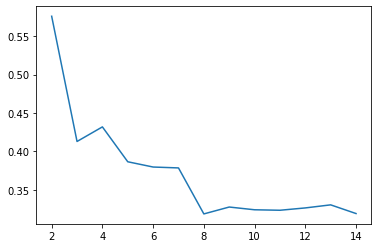

In [39]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])

### Sum of Squared Distances

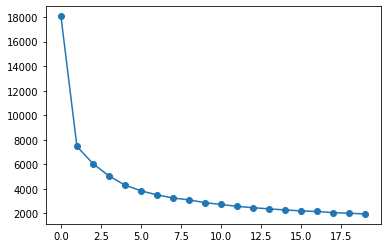

In [40]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=100)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd,marker='o')

In [41]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(max_iter=50, n_clusters=5)

In [42]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([df_all, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['household_key', 'Amount','Frequency','Recency','AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','HOUSEHOLD_SIZE_DESC','ClusterID']
RFM_km.head()

,household_key,Amount,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,ClusterID
0,1,4310.16,1708,6 days,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,0
1,2,1948.09,711,44 days,NaN,NaN,NaN,NaN,NaN,NaN,4
2,3,2633.20,920,9 days,NaN,NaN,NaN,NaN,NaN,NaN,1
3,5,779.06,222,9 days,NaN,NaN,NaN,NaN,NaN,NaN,1
4,6,5724.33,1771,5 days,NaN,NaN,NaN,NaN,NaN,NaN,3


### 最後看一下各組別的Amount_mean	Frequency_mean	Recency_mean

In [43]:
RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [44]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,5676.035356,1976.235955,5.602996
1,1,1406.372634,498.396273,6.962733
2,2,2746.816227,975.796834,7.467018
3,3,4742.779756,1661.109756,6.345528
4,4,1130.953903,393.612903,30.170968


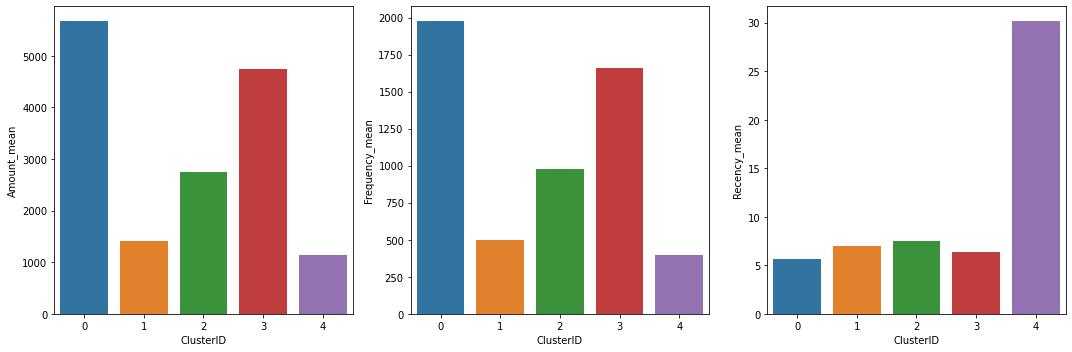

In [45]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.barplot(x=df.ClusterID, y=df.Amount_mean, ax = axs[0])
sns.barplot(x=df.ClusterID, y=df.Frequency_mean, ax = axs[1])
sns.barplot(x=df.ClusterID, y=df.Recency_mean, ax = axs[2])
plt.tight_layout()            
plt.show()

### 將四分位距的分組與k-means分組結果結合

In [46]:
RFM_df.head()

,Recency,Frequency,SALES_VALUE,R,F,M,RFM_Segment,RFM_Score,level
household_key,,,,,,,,,
1,6 days,1708,4310.16,3,4,4,344,11,重要價值客戶
2,44 days,711,1948.09,1,2,2,122,5,一般挽留客戶
3,9 days,920,2633.20,2,3,3,233,8,重要保持客戶
5,9 days,222,779.06,2,1,1,211,4,一般挽留客戶
6,5 days,1771,5724.33,3,4,4,344,11,重要價值客戶


In [47]:
RFM_df_new = RFM_df[['R','F','M','RFM_Segment','level']]

In [48]:
RMF_merge = RFM_km.merge(RFM_df_new,on='household_key')

In [63]:
RMF_merge.head()

,household_key,Amount,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,ClusterID,R,F,M,RFM_Segment,level
0,1,4310.16,1708,6,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,0,3,4,4,344,重要價值客戶
1,2,1948.09,711,44,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2,2,122,一般挽留客戶
2,3,2633.20,920,9,NaN,NaN,NaN,NaN,NaN,NaN,1,2,3,3,233,重要保持客戶
3,5,779.06,222,9,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1,1,211,一般挽留客戶
4,6,5724.33,1771,5,NaN,NaN,NaN,NaN,NaN,NaN,3,3,4,4,344,重要價值客戶


In [50]:
RMF_merge.query('ClusterID == 0')

,household_key,Amount,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,ClusterID,R,F,M,RFM_Segment,level
0,1,4310.16,1708,6,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,0,3,4,4,344,重要價值客戶
6,8,5344.45,1958,6,25-34,Single,25-34K,Unknown,2 Adults Kids,3,0,3,4,4,344,重要價值客戶
13,18,6402.65,1833,1,45-54,Married,100-124K,Homeowner,2 Adults No Kids,2,0,4,4,4,444,重要價值客戶
14,20,6034.25,1980,1,25-34,Married,75-99K,Renter,2 Adults No Kids,2,0,4,4,4,444,重要價值客戶
16,22,5247.92,1579,1,45-54,Married,75-99K,Homeowner,2 Adults No Kids,2,0,4,4,4,444,重要價值客戶
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,2446,4400.57,1426,5,35-44,Single,125-149K,Homeowner,2 Adults No Kids,2,0,3,4,4,344,重要價值客戶
1966,2447,7415.84,1838,5,35-44,Married,25-34K,Homeowner,2 Adults No Kids,2,0,3,4,4,344,重要價值客戶
1972,2455,5149.56,1191,2,45-54,Unknown,25-34K,Homeowner,2 Adults No Kids,2,0,4,3,4,434,重要價值客戶
1998,2488,5663.39,1971,8,45-54,Unknown,35-49K,Homeowner,Single Female,1,0,2,4,4,244,重要保持客戶


In [51]:
RMF_merge.query('ClusterID == 1')

,household_key,Amount,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,ClusterID,R,F,M,RFM_Segment,level
2,3,2633.20,920,9,NaN,NaN,NaN,NaN,NaN,NaN,1,2,3,3,233,重要保持客戶
3,5,779.06,222,9,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1,1,211,一般挽留客戶
9,14,2236.17,874,8,NaN,NaN,NaN,NaN,NaN,NaN,1,2,3,3,233,重要保持客戶
10,15,971.54,303,7,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1,1,211,一般挽留客戶
17,23,2759.14,739,1,NaN,NaN,NaN,NaN,NaN,NaN,1,4,2,3,423,一般價值客戶
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2471,933.60,397,1,NaN,NaN,NaN,NaN,NaN,NaN,1,4,2,1,421,一般發展客戶
1985,2472,1214.98,338,6,NaN,NaN,NaN,NaN,NaN,NaN,1,3,1,2,312,一般發展客戶
1995,2485,1420.52,571,6,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2,2,322,一般發展客戶
1999,2490,699.16,282,16,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,111,一般挽留客戶


In [52]:
RMF_merge.query('ClusterID == 2')

,household_key,Amount,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,ClusterID,R,F,M,RFM_Segment,level
5,7,3400.05,1280,3,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,2,3,3,3,333,重要價值客戶
11,16,1319.72,509,22,45-54,Unknown,50-74K,Homeowner,Single Female,1,2,1,2,2,122,一般挽留客戶
12,17,4422.40,986,23,65+,Unknown,Under 15K,Homeowner,2 Adults No Kids,2,2,1,3,4,134,重要保持客戶
19,25,3067.81,1014,7,35-44,Single,50-74K,Unknown,Unknown,1,2,2,3,3,233,重要保持客戶
25,31,3542.22,1046,2,35-44,Unknown,35-49K,Homeowner,2 Adults No Kids,2,2,4,3,3,433,重要價值客戶
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2486,3134.24,1488,1,35-44,Unknown,25-34K,Unknown,Single Male,1,2,4,4,3,443,重要價值客戶
2001,2494,2007.99,607,10,35-44,Single,50-74K,Homeowner,2 Adults No Kids,2,2,2,2,2,222,一般挽留客戶
2002,2496,3945.64,1458,29,45-54,Married,75-99K,Homeowner,Unknown,3,2,1,4,4,144,重要保持客戶
2004,2498,2529.15,855,2,25-34,Single,50-74K,Homeowner,2 Adults No Kids,2,2,4,3,3,433,重要價值客戶


In [53]:
RMF_merge.query('ClusterID == 3')

,household_key,Amount,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,ClusterID,R,F,M,RFM_Segment,level
4,6,5724.33,1771,5,NaN,NaN,NaN,NaN,NaN,NaN,3,3,4,4,344,重要價值客戶
30,36,4860.41,1352,4,NaN,NaN,NaN,NaN,NaN,NaN,3,3,4,4,344,重要價值客戶
52,64,3911.21,1394,1,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,4,444,重要價值客戶
55,68,4438.48,2161,6,NaN,NaN,NaN,NaN,NaN,NaN,3,3,4,4,344,重要價值客戶
56,69,5700.85,2083,1,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,4,444,重要價值客戶
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,2475,5021.31,1625,27,NaN,NaN,NaN,NaN,NaN,NaN,3,1,4,4,144,重要保持客戶
1989,2478,3354.42,1537,6,NaN,NaN,NaN,NaN,NaN,NaN,3,3,4,3,343,重要價值客戶
1991,2481,4268.03,1450,2,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,4,444,重要價值客戶
1994,2484,6843.55,2265,5,NaN,NaN,NaN,NaN,NaN,NaN,3,3,4,4,344,重要價值客戶


In [54]:
RMF_merge.query('ClusterID == 4')

,household_key,Amount,Frequency,Recency,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,ClusterID,R,F,M,RFM_Segment,level
1,2,1948.09,711,44,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2,2,122,一般挽留客戶
7,9,797.42,220,23,NaN,NaN,NaN,NaN,NaN,NaN,4,1,1,1,111,一般挽留客戶
8,10,234.34,70,27,NaN,NaN,NaN,NaN,NaN,NaN,4,1,1,1,111,一般挽留客戶
15,21,764.11,272,30,NaN,NaN,NaN,NaN,NaN,NaN,4,1,1,1,111,一般挽留客戶
40,50,351.39,126,37,NaN,NaN,NaN,NaN,NaN,NaN,4,1,1,1,111,一般挽留客戶
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,2474,504.74,276,22,NaN,NaN,NaN,NaN,NaN,NaN,4,1,1,1,111,一般挽留客戶
1988,2477,1670.59,513,22,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2,2,122,一般挽留客戶
1990,2480,1668.67,556,25,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2,2,122,一般挽留客戶
1992,2482,2690.93,1014,30,NaN,NaN,NaN,NaN,NaN,NaN,4,1,3,3,133,重要保持客戶
